**Individual Question**: “How do the costs of various housing units across different communities affect vacancy rates, and has the timeline between the two years affected those costs? Does this in turn affect vacancy rates as well and by how much?” 

# **Data Cleaning:**
- Some remaining excel cleaning was done for both the Individual Town Summaries, as well as Table 9 (Population Sizes of Communities)
    - Individual Town Summaries --> isolating "Number of Units and Vacancies by Unit Type", reformatting so it doesn't appear as a mess in csv format, and replacing % with decimal values so it can be read as a number
    - Table 9 --> Manually replaced a few town names (5 data points which were formatted weirdly) 

- Rest of Data Cleaning was done in python (demonstrated below) for tables 8 and 10:

In [2]:
# Cleaning Table 10: Population Values (this will be used for splitting communities into small, medium and large sections)
import pandas as pd
pd.options.mode.chained_assignment = None # cancels SettingWithCopyWarning on inputting the value for Grande Cache, which doesn't actually cause any issues

# read dataset csvs
table6 = pd.read_csv("Matthew's Data/Table6.csv")
table8 = pd.read_csv("Matthew's Data/Table8.csv")
table10 = pd.read_csv("Matthew's Data/table10.csv")

# from the communities in table8, get each individual community and put as list (these are communities which we have the data for)
community_names = table8["Community"].unique().tolist()

# filter the population csv based on if it exists in the observed commmunities list (those included in table 8) using .isin()
table10_byAreaNames = table10[table10["Area Name"].isin(community_names)]

# IMPUTATION: Grande Cache's population value is marked with "--", 
table10_byAreaNames.loc[table10_byAreaNames["Area Name"] == "Grande Cache"] = table10_byAreaNames.loc[table10_byAreaNames["Area Name"] == "Grande Cache"].replace("--", "3276")

# convert 2022 and 2021 column to integer values (since it is currently being read as string) with .apply()
table10_byAreaNames["2022"] = table10_byAreaNames["2022"].apply(lambda x: int(x))

# We take the most recent population for dividing into bins (2022), so we drop the 2021 population
table10_byAreaNames.drop(["2021"],axis=1,inplace=True)

# display populations (in alphabetical order)
table10_cleaned = table10_byAreaNames.sort_values("Area Name")
table10_cleaned

#  .tolist() https://numpy.org/doc/2.2/reference/generated/numpy.ndarray.tolist.html 
# Population Table (table10.csv) exported from https://open.alberta.ca/dataset/alberta-population-estimates-data-tables 
# SettingWithCopyWarning: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas    
# .isin() method https://www.geeksforgeeks.org/how-to-check-if-pandas-column-has-value-from-list-of-string/ 
# convert to int using .apply() https://www.geeksforgeeks.org/convert-a-dataframe-column-to-integer-in-pandas/ 
# Grande Cache information 

,Area Name,Type,2022
308,Athabasca,T,2827
330,Banff,T,9347
296,Barrhead,T,4503
26,Bassano,T,1255
409,Beaverlodge,T,2371
...,...,...,...
183,Vegreville,T,5819
190,Vermilion,T,3978
59,Vulcan,T,1825
131,Wainwright,T,6741


In [3]:
# Cleaning Table8: Remove table8 values where weighted rent is 0
table8 = table8[table8["2021 Weighted Rent"] != 0]
table8 = table8[table8["2022 Weighted Rent"] != 0]
table8

,Community,Unit Type,2021 Weighted Rent,2022 Weighted Rent
0,Athabasca,1 - Bedroom,840,852
1,Athabasca,2 - Bedroom,912,931
2,Athabasca,3 - Bedroom,1026,980
3,Athabasca,Bachelor,706,719
4,Banff,1 - Bedroom,1318,1435
...,...,...,...,...
247,Wainwright,Bachelor,450,434
248,Westlock,1 - Bedroom,775,768
249,Westlock,2 - Bedroom,881,881
250,Westlock,3 - Bedroom,972,963


--------------------------------------------
### **Cleaning data for individual summaries**

In [4]:
# Divide population into different sizes (approximately 1/3rds for small, medium and large population sizes)
population_labels, population_bins = pd.qcut(table10_cleaned["2022"], 3, retbins=True) # use pd.qcut to split data into 1/3rds for each size
print("Bin Divisions:",population_bins.astype(int)) # display the bin bounds (as integers as well)

# https://pandas.pydata.org/docs/reference/api/pandas.qcut.html
# https://stackoverflow.com/questions/54565805/how-to-get-the-bin-value-by-qcut 

Bin Divisions: [  719  2492  5760 14996]


This means we are going to divide the population into the following sizes *([] = Included, () = Excluded)*:
- Small: [719, 2492]
- Medium: (2492, 5760]
- Large: (5760, 14996]

In [5]:
# List of "Small Towns" (sizes 719-2,492)
small_towns = table10_cleaned[table10_cleaned["2022"].between(population_bins[0], population_bins[1])] # used .between to filter table10 to just towns in between population size 719 and 2492 (lower bound included here)
small_towns

# .between() method https://pandas.pydata.org/docs/reference/api/pandas.Series.between.html 

,Area Name,Type,2022
26,Bassano,T,1255
409,Beaverlodge,T,2371
4,Bow Island,T,2129
137,Bowden,T,1297
202,Bruderheim,T,1392
145,Eckville,T,1079
260,Elk Point,T,1455
417,Falher,T,1034
401,Fox Creek,T,1841
48,Hanna,T,2492


In [6]:
# list of "Medium Size Towns"(size 2,493-5,760)
med_towns = table10_cleaned[table10_cleaned["2022"].between(population_bins[1], population_bins[2], inclusive='right')] # filter towns by population size 2,492-5,760 (excluding lower bound)
med_towns

,Area Name,Type,2022
308,Athabasca,T,2827
296,Barrhead,T,4503
85,Black Diamond,T,2825
29,Cardston,T,3828
96,Carstairs,T,5181
38,Claresholm,T,3957
98,Didsbury,T,5172
425,Fairview,T,2914
36,Fort Macleod,T,3499
402,Grande Cache,T,3276


In [7]:
# list of "Large Towns" (size 5,760-14,996)
big_towns = table10_cleaned[table10_cleaned["2022"].between(population_bins[2], population_bins[3], inclusive='right')]
big_towns

,Area Name,Type,2022
330,Banff,T,9347
150,Blackfalds,T,11363
256,Bonnyville,T,6632
18,Coaldale,T,9179
322,Crowsnest Pass,SM,5910
226,Drayton Valley,T,7482
68,Drumheller,T,8231
320,Edson,T,8399
81,High River,T,14996
319,Hinton,T,9933


I sampled a few towns by community size range (small, medium, big), selecting those with various trends in rent (including how large/small compared to average and whether there is increase or decrease in rent) and how it affects both individual and overall vacancy between those two years, some which are similar and can be compared to similar towns in other sizes.

Reasons why I chose these towns based on community attributes related to rents:

<u>Small</u>:
- Fox Creek --> Rents higher than average and increasing, also wonder how this compares to slave lake which shows similar trends but is from a larger population size
- Falher --> Noticeably lower Rents than Average 
- Millet --> Less housing units, slightly higher costs 
- Mclennan --> Less housing units, lower costs than average

<u>Medium</u>:
- Jasper --> Rents are much higher than average, but experienced NO change in vacancies (0% both years)
- Claresholm --> Rents below average and has an increasing trend 
- Grimshaw --> Less housing units -> rents above average 
- Raymond --> Less housing units -> rents below average 

<u>Large</u>:
- Slave Lake --> Rents much higher than average and incresing (similar to Fox Creek)
- Ponoka --> Similar trend to High Prairie (3bed higher than others, which are closer to average) 
- Banff --> Higher rents than average and also 4+ Bedrooms -> compared to fort macleod
- Taber --> Rents below average, increase trend -> increase in vacancy -> compared with claresholm
- Edson --> Similar to Ponoka BUT rents for 1 beds,2 beds and bachelor are now noticeably above average 

-------------

In [8]:
# Tuples for multilevel index where outer is the two years and inner is the unit type
multigrouping = [("2021", "Bachelor"),("2021", "1 - Bedroom"), ("2021", "2 - Bedroom"), ("2021", "3 - Bedroom"),("2021", "4+ Bedroom"),
                  ("2022", "Bachelor"), ("2022", "1 - Bedroom"), ("2022", "2 - Bedroom"), ("2022", "3 - Bedroom"),("2022", "4+ Bedroom"),]

## Small Towns

In [ ]:
# Individual Vacancies for Fox Creek in 2022
foxcreek_vacancies = pd.read_csv("Matthew's Data/Summaries/Fox Creek Summary.csv")

# Set row index as the labels - # of units, # of vacancies, and percent (vacancy rate)
foxcreek_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)

# Convert decimals to percent in "Percentage" row
foxcreek_vacancies.loc["Percentage"] = foxcreek_vacancies.loc["Percentage"].apply(lambda x: x*100)

# Add 2021 Vacancies, since they were only found in pdf form, had to manually get the values (applies to all communities, individual unit vacancies) 
foxcreek_vacancies_2021 = pd.DataFrame({
    "Bachelor": [3,0,0], 
    "1 - Bedroom":[57,28, 49.1], 
    "2 - Bedroom": [109, 62, 56.9], 
    "3 - Bedroom": [14, 5, 35.7], 
    "4+ Bedroom": [0,0,0]})

# universal "index setter" which makes the row names "Number of Units", "Vacancies", "Percentage"
attributes = foxcreek_vacancies.index

# concatenate both 2021 and 2022 vacancies into a single dataframe
foxcreek_vacancies_2021.index = attributes
foxcreek_vacancies = pd.concat([foxcreek_vacancies_2021, foxcreek_vacancies], axis=1)

# use multilevel indexing to group each unit type under year (2021, 2022) using  the "multigrouping" tuple array defined earlier
foxcreek_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
foxcreek_vacancies

# 2021 individual unit vacancies (for all) https://open.alberta.ca/dataset/fb9452c6-395e-45a8-8149-645956fd83ac/resource/6637b927-5e8c-4ca1-87a1-504874487a41/download/sh-apartment-vacancy-rental-cost-survey-2021.pdf
# Concatenating dataframes https://pandas.pydata.org/docs/reference/api/pandas.concat.html  

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           3        57.0   
Vacancies                                                 0        28.0   
Percentage                                                0        49.1   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          109.0        14.0   
Vacancies                                                 62.0         5.0   
Percentage                                                56.9        35.7   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      1.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           36.0        55.0   
Vacancies                                                 21.0        35.0   
Percentage                                                58.3        63.6   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            5.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [10]:
# Falher
falher_vacancies = pd.read_csv("Matthew's Data/Summaries/Falher Summary.csv")
falher_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
falher_vacancies = falher_vacancies.dropna(how='all',axis=1)
falher_vacancies = falher_vacancies.dropna(how='all',axis=0)
falher_vacancies.loc["Percentage"] = falher_vacancies.loc["Percentage"].apply(lambda x: x*100)
falher_vacancies_2021 = pd.DataFrame({
    "Bachelor": [2,0,0], 
    "1 - Bedroom":[18,0,0], 
    "2 - Bedroom": [21, 1, 0.048], 
    "3 - Bedroom": [7, 1, 0.143], 
    "4+ Bedroom": [0,0,0]})
falher_vacancies_2021.index = attributes
falher_vacancies = pd.concat([falher_vacancies_2021, falher_vacancies], axis=1)
falher_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
falher_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           2          18   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         21.000       7.000   
Vacancies                                                1.000       1.000   
Percentage                                               0.048       0.143   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      2.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           20.0        24.0   
Vacancies                                                  3.0         2.0   
Percentage                                                15.0         8.3   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            7.0        0.0  
Vacancies                                                  1.0        0.0  
Percentage                                                14.3        0.0

In [11]:
# Millet
millet_vacancies = pd.read_csv("Matthew's Data/Summaries/Millet Summary.csv")
millet_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
millet_vacancies = millet_vacancies.dropna(how='all',axis=1)
millet_vacancies = millet_vacancies.dropna(how='all',axis=0)
millet_vacancies.loc["Percentage"] = millet_vacancies.loc["Percentage"].apply(lambda x: x*100)
millet_vacancies_2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[4,1,25], 
    "2 - Bedroom": [15,2,13.3], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})
millet_vacancies_2021.index = attributes
millet_vacancies = pd.concat([millet_vacancies_2021, millet_vacancies], axis=1)
millet_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
millet_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0           4   
Vacancies                                                 0           1   
Percentage                                                0          25   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           15.0           0   
Vacancies                                                  2.0           0   
Percentage                                                13.3           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            5.0        14.0   
Vacancies                                                  0.0         0.0   
Percentage                                                 0.0         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [12]:
# Mclennan
mclennan_vacancies = pd.read_csv("Matthew's Data/Summaries/Mclennan Summary.csv")
mclennan_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
mclennan_vacancies = mclennan_vacancies.dropna(how='all',axis=1)
mclennan_vacancies = mclennan_vacancies.dropna(how='all',axis=0)
mclennan_vacancies.loc["Percentage"] = mclennan_vacancies.loc["Percentage"].apply(lambda x: x*100)
mclennan_vacancies_2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[12,0,0], 
    "2 - Bedroom": [15,0,0], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})
mclennan_vacancies_2021.index = attributes
mclennan_vacancies = pd.concat([mclennan_vacancies_2021, mclennan_vacancies], axis=1)
mclennan_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
mclennan_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0          12   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             15           0   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           12.0        12.0   
Vacancies                                                  1.0         0.0   
Percentage                                                 8.3         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

------

# Medium Towns

In [ ]:
# Jasper
# This (and banff) had to manually get the 2022 individual vacancy values from the linked pdf for since sheet didn't have it 
jasper_vacancies = pd.DataFrame({
    "Bachelor": [149,0,0], 
    "1 - Bedroom":[112,0,0], 
    "2 - Bedroom": [75,0,0], 
    "3 - Bedroom": [21,0,0], 
    "4+ Bedroom": [0,0,0]
})
jasper_vacancies.index = attributes # set same row names for this custom dataframe
jasper_vacancies.loc["Percentage"] = jasper_vacancies.loc["Percentage"].apply(lambda x: x*100)
jasper_vacancies2021 = pd.DataFrame({
    "Bachelor": [147,0,0], 
    "1 - Bedroom":[82,0,0], 
    "2 - Bedroom": [26,0,0], 
    "3 - Bedroom": [2,0,0], 
    "4+ Bedroom": [0,0,0]
})
jasper_vacancies2021.index = attributes
jasper_vacancies = pd.concat([jasper_vacancies2021, jasper_vacancies], axis=1)
jasper_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
jasper_vacancies

# pdf for 2022 individual vacancies: (https://open.alberta.ca/dataset/fb9452c6-395e-45a8-8149-645956fd83ac/resource/e07f0421-a710-4c3c-9bbf-392285493e6b/download/scss-apartment-vacancy-rental-cost-survey-2022.pdf) 

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                         147          82   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             26           2   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      149   
Vacancies                                                   0        0   
Percentage                                                  0        0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            112          75   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                             21          0  
Vacancies                                                    0          0  
Percentage                                                   0          0

In [14]:
# claresholm
claresholm_vacancies = pd.read_csv("Matthew's Data/Summaries/Claresholm Summary.csv")
claresholm_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
claresholm_vacancies = claresholm_vacancies.dropna(how='all',axis=1)
claresholm_vacancies = claresholm_vacancies.dropna(how='all',axis=0)
claresholm_vacancies.loc["Percentage"] = claresholm_vacancies.loc["Percentage"].apply(lambda x: x*100)
claresholm_vacancies2021 = pd.DataFrame({
    "Bachelor": [16,0,0], 
    "1 - Bedroom":[6,0,0], 
    "2 - Bedroom": [29,0,0], 
    "3 - Bedroom": [8,0,0], 
    "4+ Bedroom": [0,0,0]
})
claresholm_vacancies2021.index = attributes
claresholm_vacancies = pd.concat([claresholm_vacancies2021, claresholm_vacancies], axis=1)
claresholm_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
claresholm_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                          16           6   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             29           8   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      1.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           12.0        52.0   
Vacancies                                                  0.0         1.0   
Percentage                                                 0.0         1.9   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            8.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [15]:
# grimshaw
grimshaw_vacancies = pd.read_csv("Matthew's Data/Summaries/Grimshaw Summary.csv")
grimshaw_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
grimshaw_vacancies = grimshaw_vacancies.dropna(how='all',axis=1)
grimshaw_vacancies = grimshaw_vacancies.dropna(how='all',axis=0)
grimshaw_vacancies.loc["Percentage"] = grimshaw_vacancies.loc["Percentage"].apply(lambda x: x*100)
grimshaw_vacancies2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[9,0,0], 
    "2 - Bedroom": [51,5,9.8], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]
})
grimshaw_vacancies2021.index = attributes
grimshaw_vacancies = pd.concat([grimshaw_vacancies2021, grimshaw_vacancies], axis=1)
grimshaw_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
grimshaw_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0           9   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           51.0           0   
Vacancies                                                  5.0           0   
Percentage                                                 9.8           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           10.0        38.0   
Vacancies                                                  0.0         4.0   
Percentage                                                 0.0        10.5   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [16]:
# raymond
raymond_vacancies = pd.read_csv("Matthew's Data/Summaries/Raymond Summary.csv")
raymond_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
raymond_vacancies = raymond_vacancies.dropna(how='all',axis=1)
raymond_vacancies = raymond_vacancies.dropna(how='all',axis=0)
raymond_vacancies.loc["Percentage"] = raymond_vacancies.loc["Percentage"].apply(lambda x: x*100)
raymond_vacancies2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[2,2,1], 
    "2 - Bedroom": [8,0,0], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]
})
raymond_vacancies2021.index = attributes
raymond_vacancies = pd.concat([raymond_vacancies2021, raymond_vacancies], axis=1)
raymond_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
raymond_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0           2   
Vacancies                                                 0           2   
Percentage                                                0           1   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                              8           0   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            2.0         2.0   
Vacancies                                                  0.0         0.0   
Percentage                                                 0.0         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

----------

# Big Towns

In [17]:
# Slave Lake
slavelake_vacancies = pd.read_csv("Matthew's Data/Summaries/Slave Lake Summary.csv")
slavelake_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
slavelake_vacancies = slavelake_vacancies.dropna(how='all',axis=1)
slavelake_vacancies = slavelake_vacancies.dropna(how='all',axis=0)
slavelake_vacancies.loc["Percentage"] = slavelake_vacancies.loc["Percentage"].apply(lambda x: x*100)
slavelake_vacancies2021 = pd.DataFrame({
    "Bachelor": [2,0,0], 
    "1 - Bedroom":[19,0,0], 
    "2 - Bedroom": [27,0,0], 
    "3 - Bedroom": [64,0,0], 
    "4+ Bedroom": [0,0,0]
})
slavelake_vacancies2021.index = attributes
slavelake_vacancies = pd.concat([slavelake_vacancies2021, slavelake_vacancies], axis=1)
slavelake_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
slavelake_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           2          19   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             27          64   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      6.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           57.0       105.0   
Vacancies                                                  2.0         3.0   
Percentage                                                 3.5         2.9   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           96.0        0.0  
Vacancies                                                 13.0        0.0  
Percentage                                                13.5        0.0

In [18]:
# Ponoka
ponoka_vacancies = pd.read_csv("Matthew's Data/Summaries/Ponoka Summary.csv")
ponoka_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
ponoka_vacancies = ponoka_vacancies.dropna(how='all',axis=1)
ponoka_vacancies = ponoka_vacancies.dropna(how='all',axis=0)
ponoka_vacancies.loc["Percentage"] = ponoka_vacancies.loc["Percentage"].apply(lambda x: x*100)
ponoka_vacancies2021 = pd.DataFrame({
    "Bachelor": [8,3,37.5], 
    "1 - Bedroom":[51,6,11.8], 
    "2 - Bedroom": [134,11,8.2], 
    "3 - Bedroom": [23,2,8.7], 
    "4+ Bedroom": [0,0,0]
})
ponoka_vacancies2021.index = attributes
ponoka_vacancies = pd.concat([ponoka_vacancies2021, ponoka_vacancies], axis=1)
ponoka_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
ponoka_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                         8.0        51.0   
Vacancies                                               3.0         6.0   
Percentage                                             37.5        11.8   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          134.0        23.0   
Vacancies                                                 11.0         2.0   
Percentage                                                 8.2         8.7   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      5.0   
Vacancies                                                   0      1.0   
Percentage                                                  0     20.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           54.0       141.0   
Vacancies                                                  1.0         3.0   
Percentage                                                 1.9         2.1   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           18.0        0.0  
Vacancies                                                  4.0        0.0  
Percentage                                                22.2        0.0

In [19]:
# Banff (also had manually extract data from the 2022 pdf)
banff_vacancies = pd.DataFrame({
    "Bachelor": [12,0,0], 
    "1 - Bedroom":[91,1,1.1], 
    "2 - Bedroom": [179,0,0], 
    "3 - Bedroom": [94,0,0], 
    "4+ Bedroom": [2,0,0]
})
banff_vacancies.index = attributes
banff_vacancies2021 = pd.DataFrame({
    "Bachelor": [51,0,0], 
    "1 - Bedroom":[99,2,2], 
    "2 - Bedroom": [133,7,5.3], 
    "3 - Bedroom": [58,0,3.4], 
    "4+ Bedroom": [2,0,0]
})
banff_vacancies2021.index = attributes
banff_vacancies = pd.concat([banff_vacancies2021, banff_vacancies], axis=1)
banff_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
banff_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                          51          99   
Vacancies                                                 0           2   
Percentage                                                0           2   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          133.0        58.0   
Vacancies                                                  7.0         0.0   
Percentage                                                 5.3         3.4   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             2       12   
Vacancies                                                   0        0   
Percentage                                                  0        0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           91.0         179   
Vacancies                                                  1.0           0   
Percentage                                                 1.1           0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                             94          2  
Vacancies                                                    0          0  
Percentage                                                   0          0

In [20]:
# Taber
taber_vacancies = pd.read_csv("Matthew's Data/Summaries/Taber Summary.csv")
taber_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
taber_vacancies = taber_vacancies.dropna(how='all',axis=1)
taber_vacancies = taber_vacancies.dropna(how='all',axis=0)
taber_vacancies.loc["Percentage"] = taber_vacancies.loc["Percentage"].apply(lambda x: x*100)
taber_vacancies2021 = pd.DataFrame({
    "Bachelor": [1,0,0], 
    "1 - Bedroom":[21,0,0], 
    "2 - Bedroom": [64,1,1.6], 
    "3 - Bedroom": [24,1,4.2], 
    "4+ Bedroom": [0,0,0]
})
taber_vacancies2021.index = attributes
taber_vacancies = pd.concat([taber_vacancies2021, taber_vacancies], axis=1)
taber_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
taber_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           1          21   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           64.0        24.0   
Vacancies                                                  1.0         1.0   
Percentage                                                 1.6         4.2   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      2.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           38.0       105.0   
Vacancies                                                  0.0         6.0   
Percentage                                                 0.0         5.7   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           37.0        0.0  
Vacancies                                                  2.0        0.0  
Percentage                                                 5.4        0.0

In [21]:
# Edson
edson_vacancies = pd.read_csv("Matthew's Data/Summaries/Edson Summary.csv")
edson_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
edson_vacancies = edson_vacancies.dropna(how='all',axis=1)
edson_vacancies = edson_vacancies.dropna(how='all',axis=0)
edson_vacancies.loc["Percentage"] = edson_vacancies.loc["Percentage"].apply(lambda x: x*100)
edson_vacancies2021 = pd.DataFrame({
    "Bachelor": [2,0,0], 
    "1 - Bedroom":[69,3,4.3], 
    "2 - Bedroom": [165,1,0.6], 
    "3 - Bedroom": [16,0,0], 
    "4+ Bedroom": [0,0,0]
})
edson_vacancies2021.index = attributes
edson_vacancies = pd.concat([edson_vacancies2021, edson_vacancies], axis=1)
edson_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
edson_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           2        69.0   
Vacancies                                                 0         3.0   
Percentage                                                0         4.3   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          165.0          16   
Vacancies                                                  1.0           0   
Percentage                                                 0.6           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      2.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           75.0       214.0   
Vacancies                                                  3.0        11.0   
Percentage                                                 4.0         5.1   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           34.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

-------

# **Visualizations + Analysis:**

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
# get mean rent by each unit type for both 2021 and 2022
mean_bachelors2022 = table8[table8["Unit Type"] == "Bachelor"]["2022 Weighted Rent"].mean()
mean_1beds2022 = table8[table8["Unit Type"] == "1 - Bedroom"]["2022 Weighted Rent"].mean()
mean_2beds2022 = table8[table8["Unit Type"] == "2 - Bedroom"]["2022 Weighted Rent"].mean()
mean_3beds2022 = table8[table8["Unit Type"] == "3 - Bedroom"]["2022 Weighted Rent"].mean()
mean_4beds2022 = table8[table8["Unit Type"] == "4+ Bedroom"]["2022 Weighted Rent"].mean()

mean_bachelors2021 = table8[table8["Unit Type"] == "Bachelor"]["2021 Weighted Rent"].mean()
mean_1beds2021 = table8[table8["Unit Type"] == "1 - Bedroom"]["2021 Weighted Rent"].mean()
mean_2beds2021 = table8[table8["Unit Type"] == "2 - Bedroom"]["2021 Weighted Rent"].mean()
mean_3beds2021 = table8[table8["Unit Type"] == "3 - Bedroom"]["2021 Weighted Rent"].mean()
mean_4beds2021 = table8[table8["Unit Type"] == "4+ Bedroom"]["2021 Weighted Rent"].mean()

# Display Results
print("2021 Mean Bachelor Rents:",mean_bachelors2021)
print("2021 Mean 1 - Bedroom Rents:",mean_1beds2021)
print("2021 Mean 2 - Bedroom Rents:",mean_2beds2021)
print("2021 Mean 3 - Bedroom Rents:",mean_3beds2021)
print("2021 Mean 4+ Bedroom Rents:",mean_4beds2021)
print()
print("2022 Mean Bachelor Rents:",mean_bachelors2022)
print("2022 Mean 1 - Bedroom Rents:",mean_1beds2022)
print("2022 Mean 2 - Bedroom Rents:",mean_2beds2022)
print("2022 Mean 3 - Bedroom Rents:",mean_3beds2022)
print("2022 Mean 4+ Bedroom Rents:",mean_4beds2022)

2021 Mean Bachelor Rents: 688.741935483871
2021 Mean 1 - Bedroom Rents: 779.925925925926
2021 Mean 2 - Bedroom Rents: 900.6101694915254
2021 Mean 3 - Bedroom Rents: 1036.625
2021 Mean 4+ Bedroom Rents: 1625.0

2022 Mean Bachelor Rents: 702.741935483871
2022 Mean 1 - Bedroom Rents: 826.0
2022 Mean 2 - Bedroom Rents: 943.1186440677966
2022 Mean 3 - Bedroom Rents: 1064.6041666666667
2022 Mean 4+ Bedroom Rents: 1708.6


In [ ]:
# helper function for graphing average rents between 2021 and 2022 on line graph, input is whether the unit type exists, and plots line graph of mean between 2021-2022 if it does
def plotmeans(bach,one,two,three,four):
    if bach == True:
        color = ""
        if four == True: 
            color = "purple"
        else: 
            color = "r"
        plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color=color)
    if one == True:
        plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
    if two == True:
        plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
    if three == True:
        plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
    if four == True:
        plt.plot([mean_4beds2021, mean_4beds2022], linestyle='dotted', color="r")

# helper function for graphing individual vacancy bargraphs
def barGraph(town_vacancies, town_name):
    vacancy_2021 = np.array(town_vacancies["2021"].loc["Vacancies"])
    vacancy_2022 = np.array(town_vacancies["2022"].loc["Vacancies"])
    num_units_2021 = np.array(town_vacancies["2021"].loc["Number of Units"])
    num_units_2022 = np.array(town_vacancies["2022"].loc["Number of Units"])
    
    x_range = np.arange(len(town_vacancies["2021"].columns))
    plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacant Units (2021)")
    plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
    plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacant Units (2022)")
    plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
    plt.title(f"Vacancy Rates by Unit Type ({town_name})")
    plt.xlabel("Unit Type")
    plt.ylabel("# of Units")
    plt.xticks(x_range, labels=town_vacancies["2021"].columns)
    plt.legend()
    plt.show()

# helper function for graphing rent line graphs
def lineGraph(town_rents, town_name):
    for i in range(len(town_rents.index)):
        plt.plot(["2021", "2022"], town_rents[["2021 Weighted Rent", "2022 Weighted Rent"]].iloc[i], label=town_rents["Unit Type"].iloc[i])
    plt.title(f"Weighted Rents 2021-2022 - {town_name}") 
    plt.xlabel("Year")
    plt.ylabel("Weighted Rent ($)")
    plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
    plt.show()

--------------

## **Analysis of Small Communities**

In [ ]:
smalltowns = ["Fox Creek", "Falher", "Millet", "Mclennan"]
costs_smalltowns = table8[table8["Community"].isin(smalltowns)]
vacancy_smalltowns = table6[table6["Community"].isin(smalltowns)]

foxcreek = costs_smalltowns[costs_smalltowns["Community"] == "Fox Creek"]
falher = costs_smalltowns[costs_smalltowns["Community"] == "Falher"] 
millet = costs_smalltowns[costs_smalltowns["Community"] == "Millet"] 
mclennan = costs_smalltowns[costs_smalltowns["Community"] == "Mclennan"]

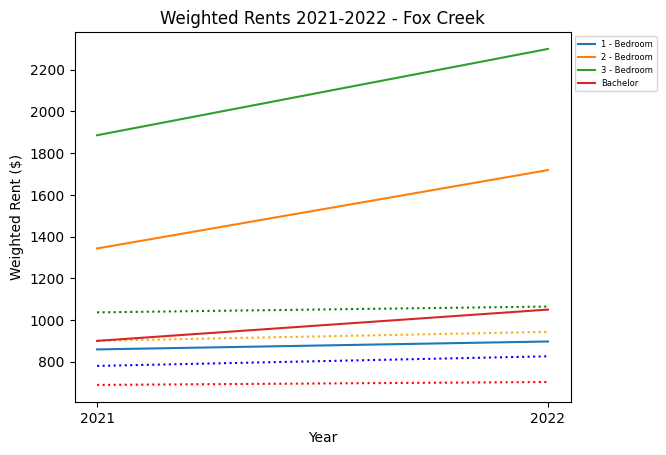

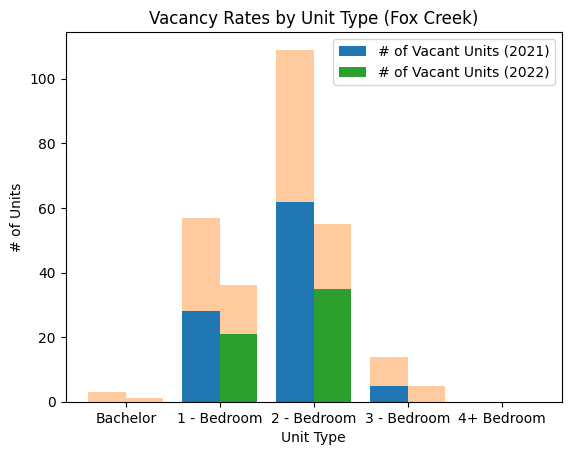

In [ ]:
plotmeans(True, True, True, True, False)
lineGraph(foxcreek, "Fox Creek")
barGraph(foxcreek_vacancies, "Fox Creek")

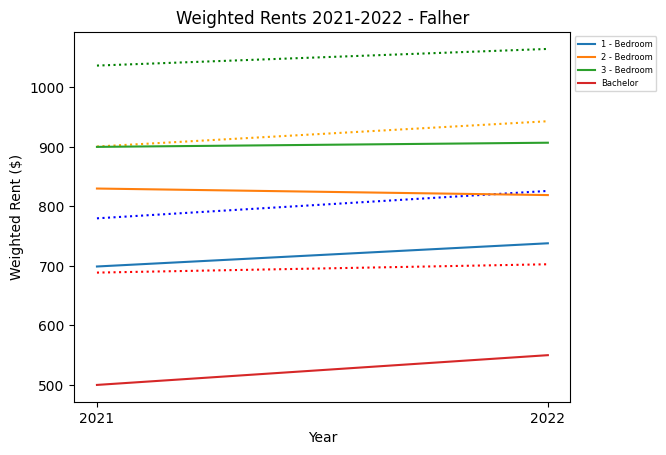

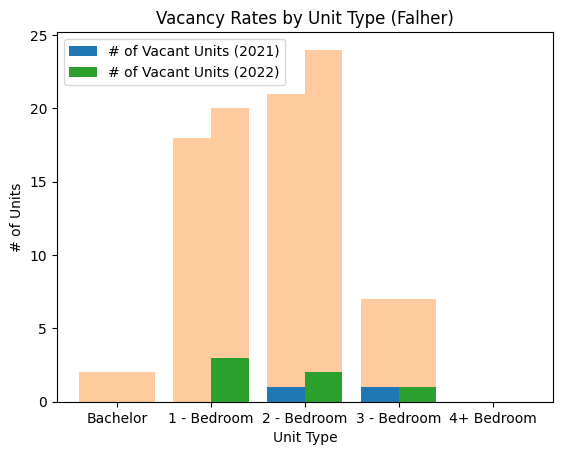

In [ ]:
plotmeans(True, True, True, True, False)
lineGraph(falher, "Falher")
barGraph(falher_vacancies, "Falher")

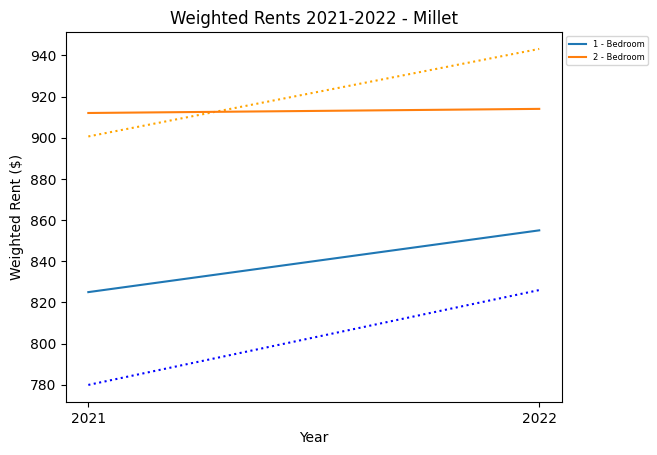

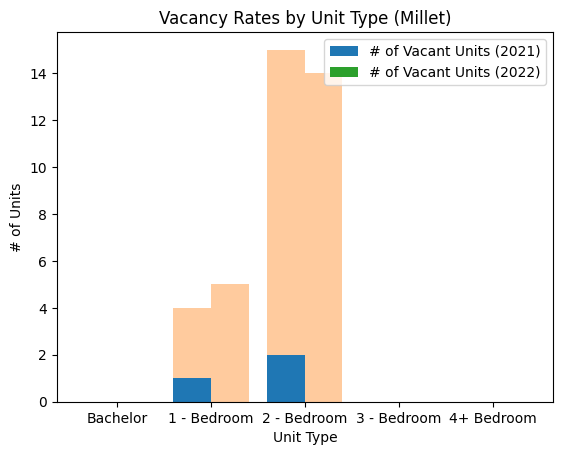

In [51]:
plotmeans(False, True, True, False, False)
lineGraph(millet, "Millet")
barGraph(millet_vacancies, "Millet")

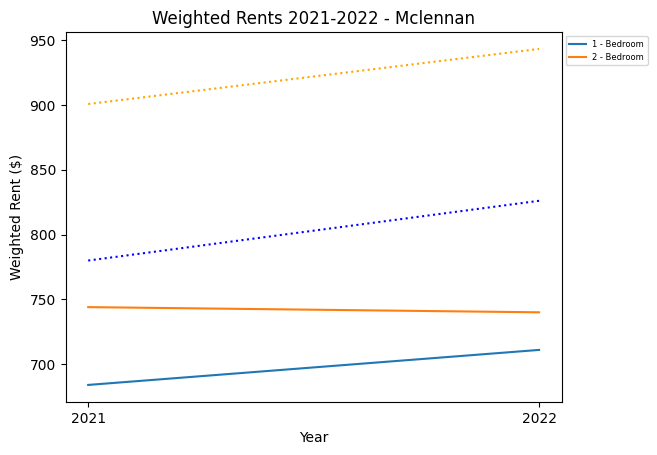

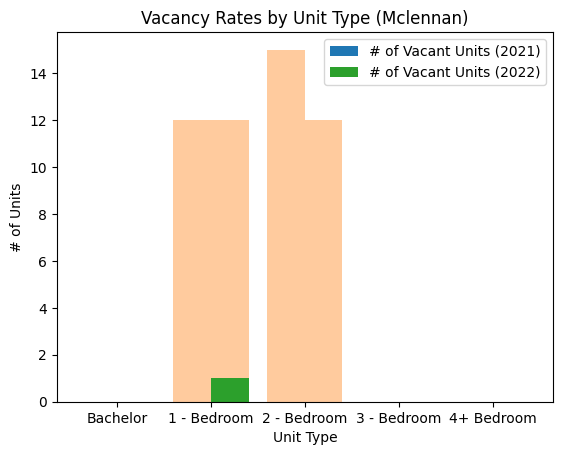

In [52]:
plotmeans(False, True, True, False, False)
lineGraph(mclennan, "Mclennan")
barGraph(mclennan_vacancies, "Mclennan")

### Overall Vacancy Rates between 2021-2022

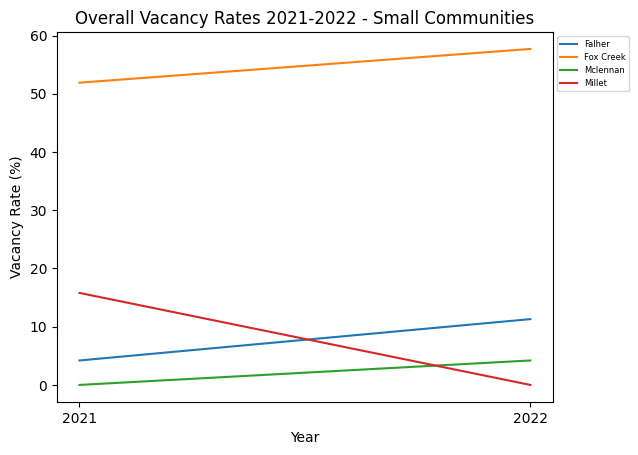

In [31]:
# small town vacancies
vacancy_smalltowns_num = vacancy_smalltowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_smalltowns.index)):
    plt.plot(["2021", "2022"], vacancy_smalltowns_num.iloc[i], label=vacancy_smalltowns["Community"].iloc[i])

plt.title("Overall Vacancy Rates 2021-2022 - Small Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

---------------------------------

## **Analysis of Medium Communities**

In [ ]:
medtowns = ["Jasper", "Claresholm", "Grimshaw", "Raymond"]

costs_medtowns = table8[table8["Community"].isin(medtowns)]
vacancy_medtowns = table6[table6["Community"].isin(medtowns)]

jasper = costs_medtowns[costs_medtowns["Community"] == "Jasper"]
claresholm = costs_medtowns[costs_medtowns["Community"] == "Claresholm"]
grimshaw = costs_medtowns[costs_medtowns["Community"] == "Grimshaw"]
raymond = costs_medtowns[costs_medtowns["Community"] == "Raymond"]

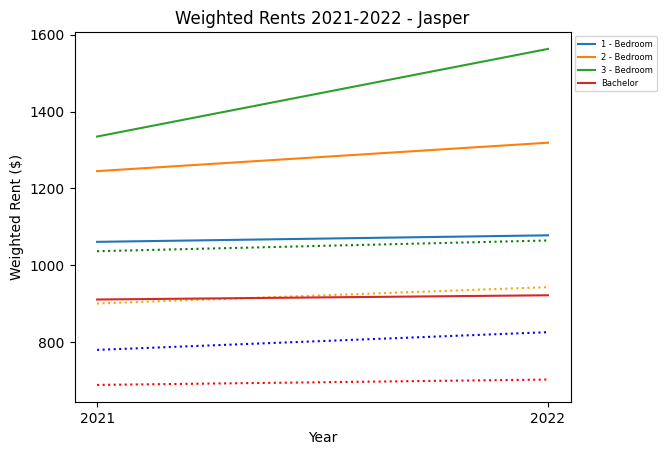

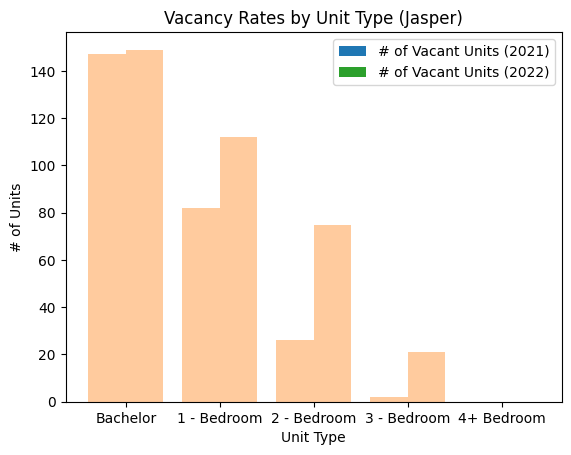

In [53]:
plotmeans(True, True, True, True, False)
lineGraph(jasper, "Jasper")
barGraph(jasper_vacancies, "Jasper")

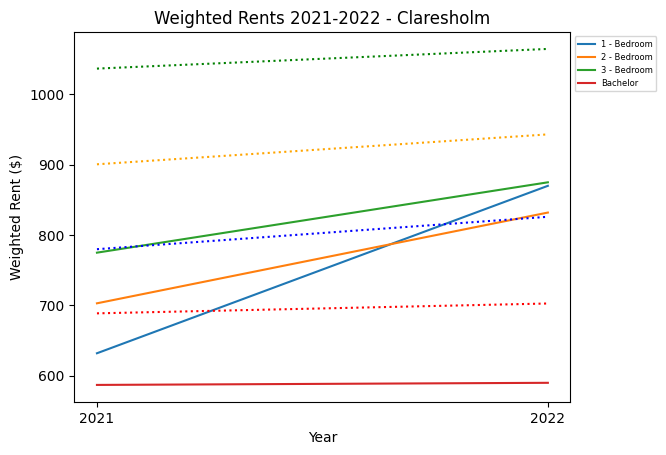

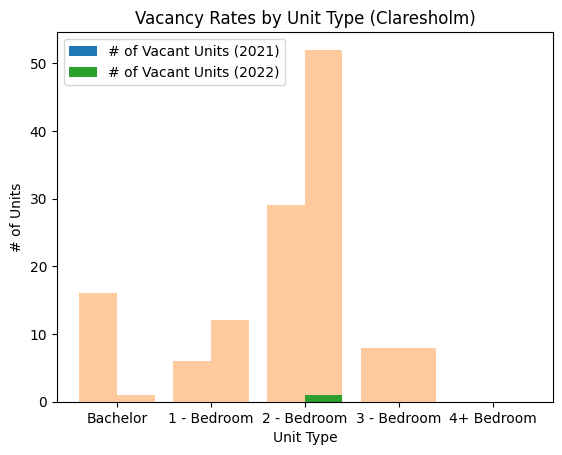

In [ ]:
plotmeans(True, True, True, True, False)
lineGraph(claresholm, "Claresholm")
barGraph(claresholm_vacancies, "Claresholm")

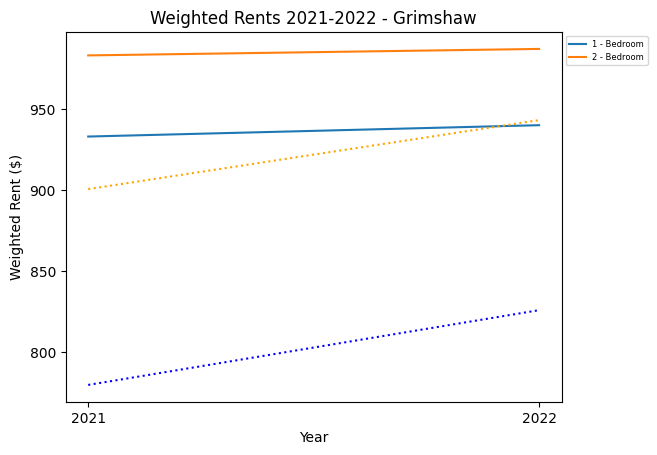

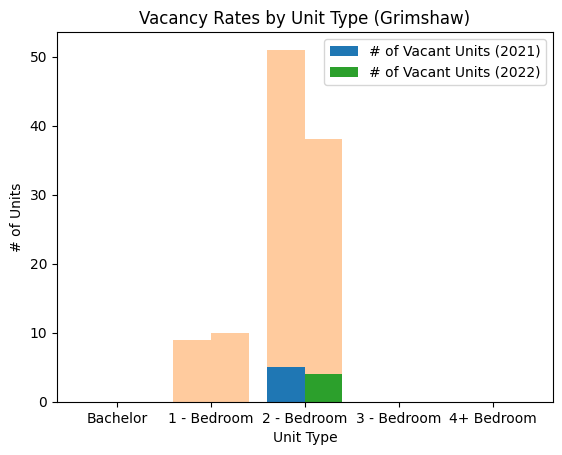

In [ ]:
plotmeans(False, True, True, False, False)
lineGraph(grimshaw, "Grimshaw")
barGraph(grimshaw_vacancies, "Grimshaw")

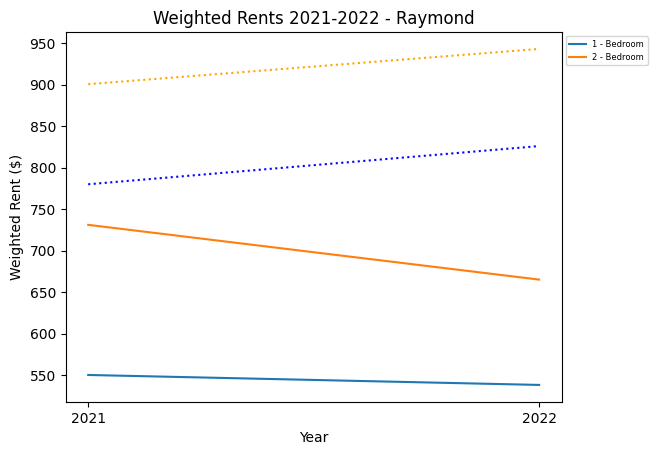

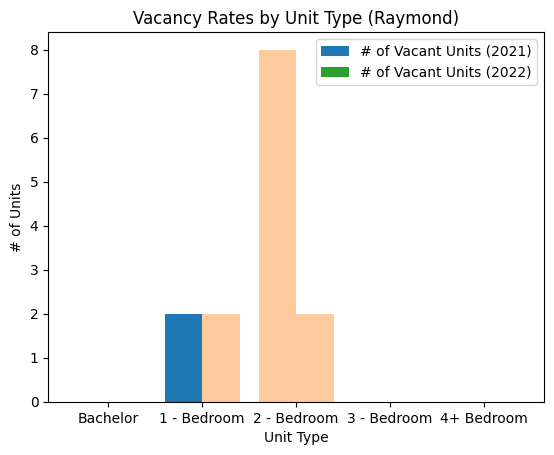

In [ ]:
plotmeans(False, True, True, False, False)
lineGraph(raymond, "Raymond")
barGraph(raymond_vacancies, "Raymond")

### Overall Vacancy Rates between 2021-2022

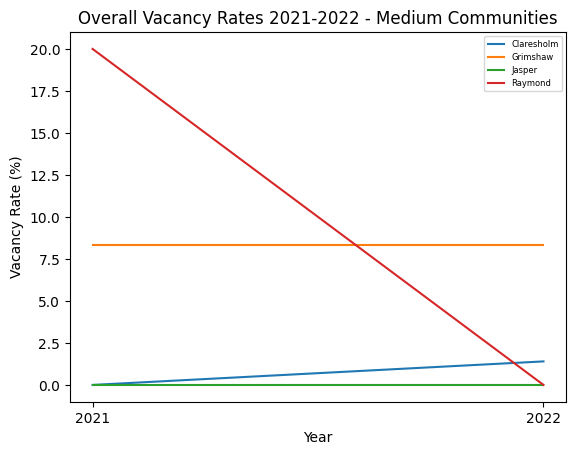

In [37]:
vacancy_medtowns_num = vacancy_medtowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_medtowns.index)):
    plt.plot(["2021", "2022"], vacancy_medtowns_num.iloc[i], label=vacancy_medtowns["Community"].iloc[i])

plt.title("Overall Vacancy Rates 2021-2022 - Medium Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

----------------------------------
## **Analysis of Large Communities**

In [ ]:
bigtowns = ["Slave Lake", "Ponoka", "Banff","Taber", "Edson"]

costs_bigtowns = table8[table8["Community"].isin(bigtowns)]
vacancy_bigtowns = table6[table6["Community"].isin(bigtowns)]

slavelake = costs_bigtowns[costs_bigtowns["Community"] == "Slave Lake"]
ponoka = costs_bigtowns[costs_bigtowns["Community"] == "Ponoka"] 
banff = costs_bigtowns[costs_bigtowns["Community"] == "Banff"]
taber = costs_bigtowns[costs_bigtowns["Community"] == "Taber"] 
edson = costs_bigtowns[costs_bigtowns["Community"] == "Edson"] 

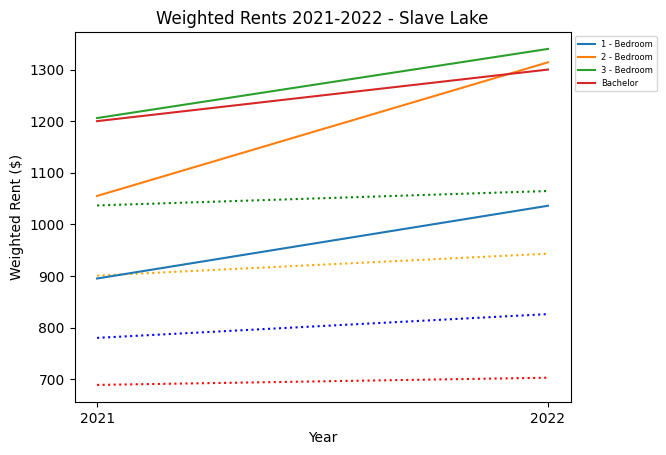

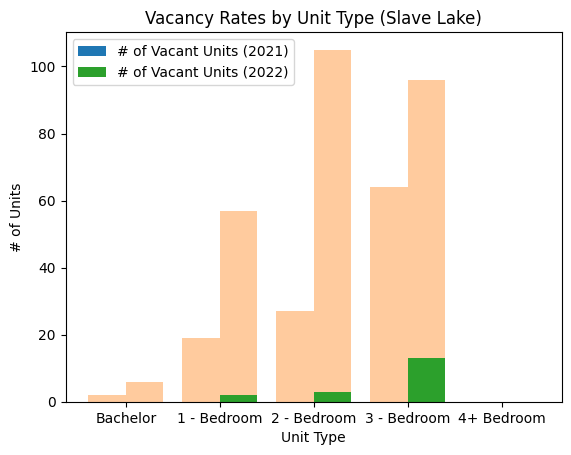

In [54]:
plotmeans(True, True, True, True, False)
lineGraph(slavelake, "Slave Lake")
barGraph(slavelake_vacancies, "Slave Lake")

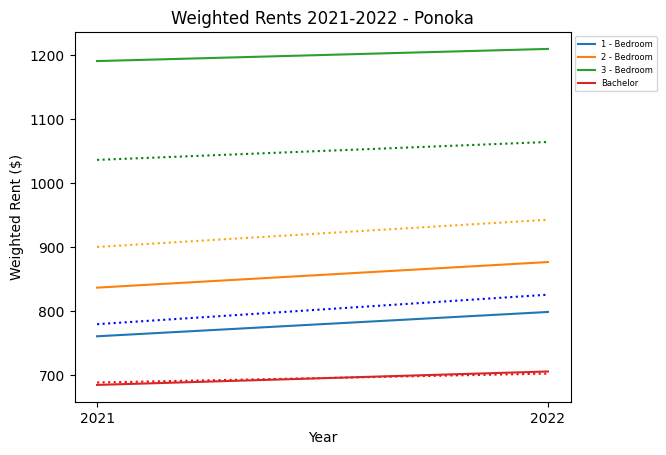

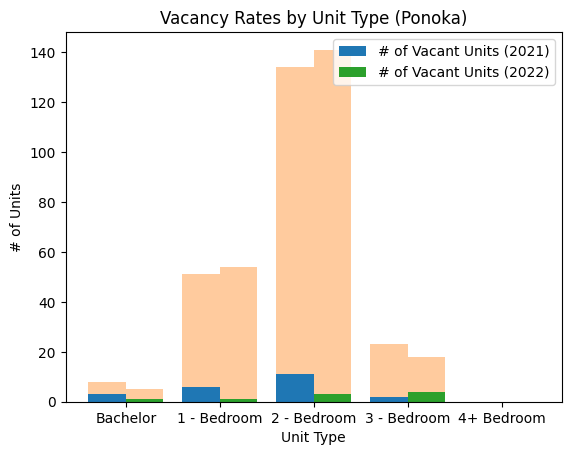

In [55]:
plotmeans(True, True, True, True, False)
lineGraph(ponoka, "Ponoka")
barGraph(ponoka_vacancies, "Ponoka")

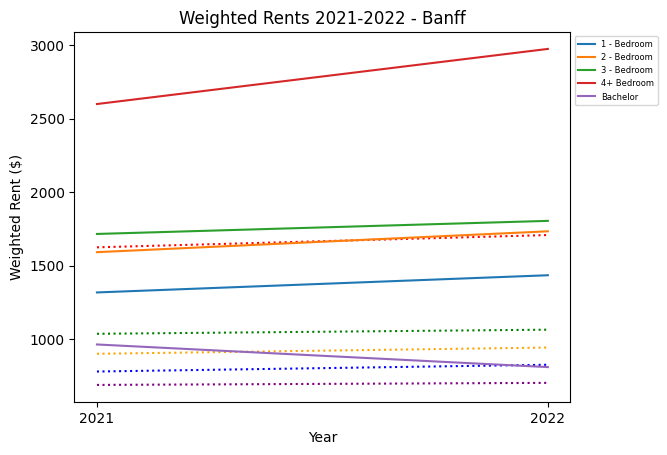

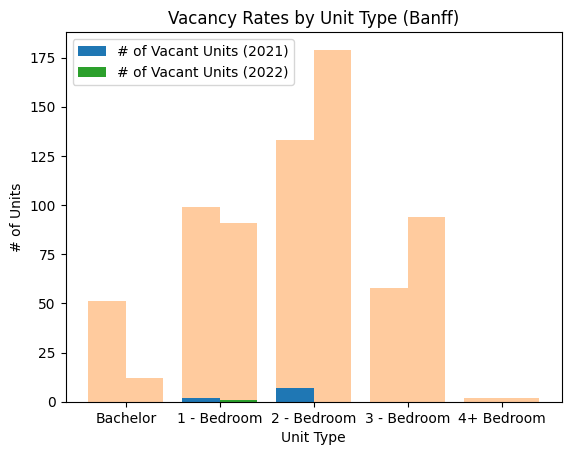

In [56]:
plotmeans(True, True, True, True, True)
lineGraph(banff, "Banff")
barGraph(banff_vacancies, "Banff")

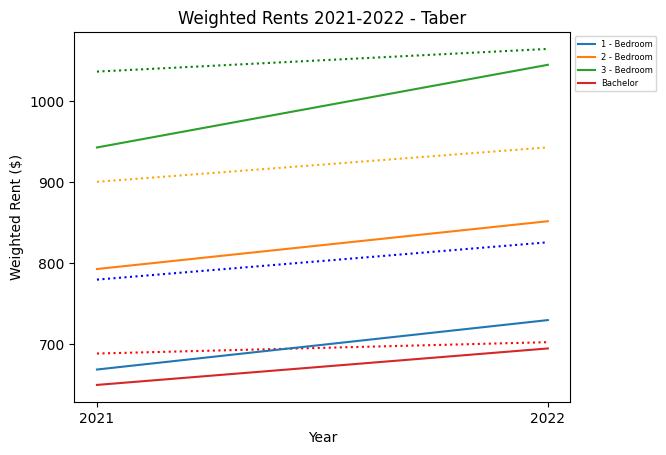

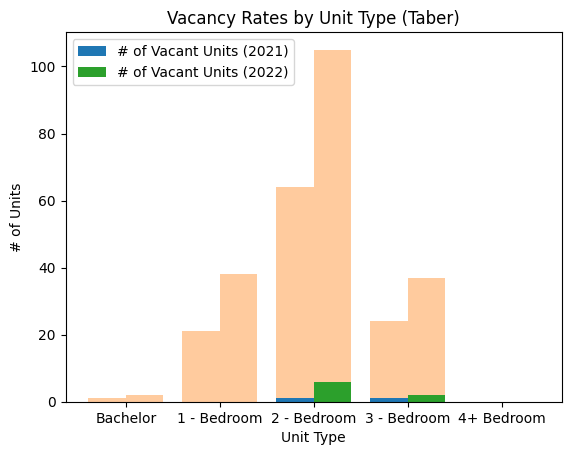

In [57]:
plotmeans(True, True, True, True, False)
lineGraph(taber, "Taber")
barGraph(taber_vacancies, "Taber")

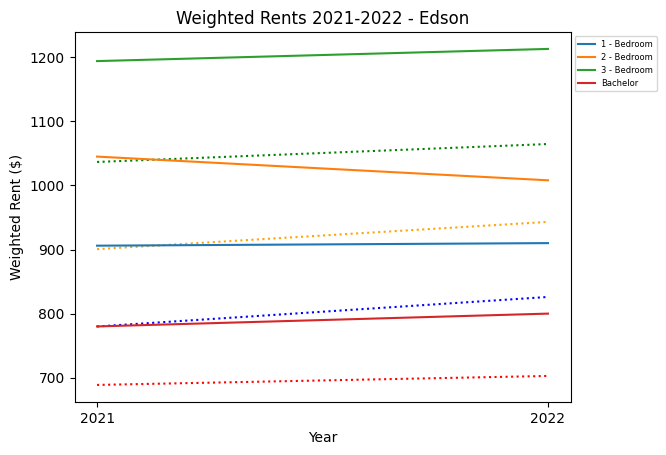

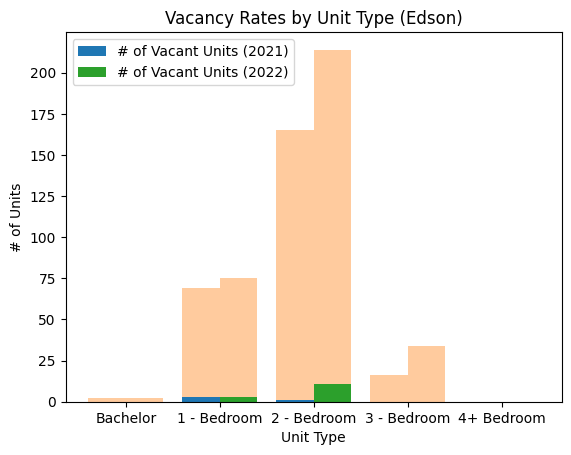

In [58]:
plotmeans(True, True, True, True, False)
lineGraph(edson, "Edson")
barGraph(edson_vacancies, "Edson")

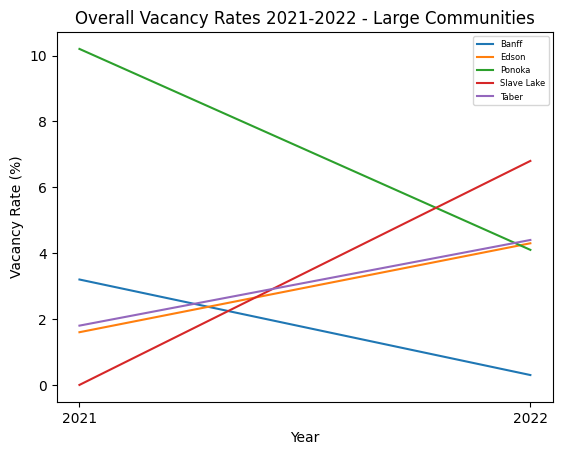

In [44]:
vacancy_bigtowns_num = vacancy_bigtowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_bigtowns.index)):
    plt.plot(["2021", "2022"], vacancy_bigtowns_num.iloc[i], label=vacancy_bigtowns["Community"].iloc[i])

plt.title("Overall Vacancy Rates 2021-2022 - Large Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

**Fox Creek (Small) vs Slave Lake (Big)**
- Fox Creek & Slave Lake both have very high rental prices and experienced a general increase in rents for all units between 2021-2022
- Both communities experienced both an overall increase in vacancy rate, as well as increase in vacancy rates of most individual units between these years
- The number of units in Fox Creek drastically dropped
    -   Fox Creek had a pretty high vacancy rate before (almost 50%) and increased even more since then
- The number of units in Slave Lake drastically increased 
    -   Slave Lake had no vacancies (0%)  in 2021 but experienced slight increase in vacancies in 2022


-----